# Imports
Run this code to import necessary modules.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd;
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold



# Variables
lets define some variables here so we can change them easier later 

In [2]:
file_path= "car details v4.csv"
data= pd.read_csv(file_path)
random_state= 42
cats= ["Make", "Fuel Type", "Transmission", "Color", "Owner", "Seller Type", "Drivetrain", "Location"]
numerical_parts= ["Year", "Kilometer", "Engine", "Max Power Part 1", "Max Power Part 2", "Max Torque Part 1", "Max Torque Part 2", 
                "Length", "Width", "Height", "Seating Capacity", "Fuel Tank Capacity"]
n_rows_categorized = len(cats) // 2 + (len(cats) % 2 > 0)
n_rows_numerical = len(numerical_parts) // 2 + (len(numerical_parts) % 2 > 0)


fixing string data which contains numeric data like Engine which has cc on every data

In [3]:
def extract_numeric_parts(s, column_name):
    if pd.isna(s):
        return pd.Series([None, None], index=[f'{column_name} Part 1', f'{column_name} Part 2'])
    matches = re.findall(r'(\d+)', s)
    part1 = int(matches[0]) if len(matches) > 0 else None
    part2 = int(matches[1]) if len(matches) > 1 else None
    return pd.Series([part1, part2], index=[f'{column_name} Part 1', f'{column_name} Part 2'])


data['Engine'] = pd.to_numeric(data['Engine'].str.replace(' cc', ''), errors='coerce')
data[['Max Power Part 1', 'Max Power Part 2']] = data['Max Power'].apply(lambda x: extract_numeric_parts(x, 'Max Power'))
data[['Max Torque Part 1', 'Max Torque Part 2']] = data['Max Torque'].apply(lambda x: extract_numeric_parts(x, 'Max Torque'))
data.drop('Max Power', axis=1, inplace=True)
data.drop('Max Torque', axis=1, inplace=True)



# Question 1

first we need to import and split our data

In [4]:

min_price= min(data['Price'])
max_price= max(data['Price'])
print("minimum price:", min_price)
print("maximum price:", max_price)
# categorized in 3 types of Price and add to our dataset
price_bins = pd.qcut(data['Price'], q=3, labels=False)
data['Price_Category'] = price_bins
#split our data to train and test I set random_state to avoid changing my shuffled data every time
def get_split_data(data):
    train_set, test_set = train_test_split(data, test_size=0.2, stratify=data['Price_Category'], random_state= random_state)
    return train_set, test_set


minimum price: 49000
maximum price: 35000000


# Question 2
in this question we need to find some interesting information about our data and we don't have any specific roadmap for it so we will see what happens in the code.

In [5]:
print(data.describe())
print("--------------------------")
print("null data::")
print(data.isnull().sum())
print("----------data structure -----------")
print(data.head())

              Price         Year     Kilometer       Engine       Length  \
count  2.059000e+03  2059.000000  2.059000e+03  1979.000000  1995.000000   
mean   1.702992e+06  2016.425449  5.422471e+04  1692.575543  4280.860652   
std    2.419881e+06     3.363564  5.736172e+04   643.736294   442.458507   
min    4.900000e+04  1988.000000  0.000000e+00   624.000000  3099.000000   
25%    4.849990e+05  2014.000000  2.900000e+04  1197.000000  3985.000000   
50%    8.250000e+05  2017.000000  5.000000e+04  1498.000000  4370.000000   
75%    1.925000e+06  2019.000000  7.200000e+04  1995.000000  4629.000000   
max    3.500000e+07  2022.000000  2.000000e+06  6592.000000  5569.000000   

             Width       Height  Seating Capacity  Fuel Tank Capacity  \
count  1995.000000  1995.000000       1995.000000         1946.000000   
mean   1767.991980  1591.735338          5.306266           52.002210   
std     135.265825   136.073956          0.822170           15.110198   
min    1475.000000  116

histograms of numerical data counts

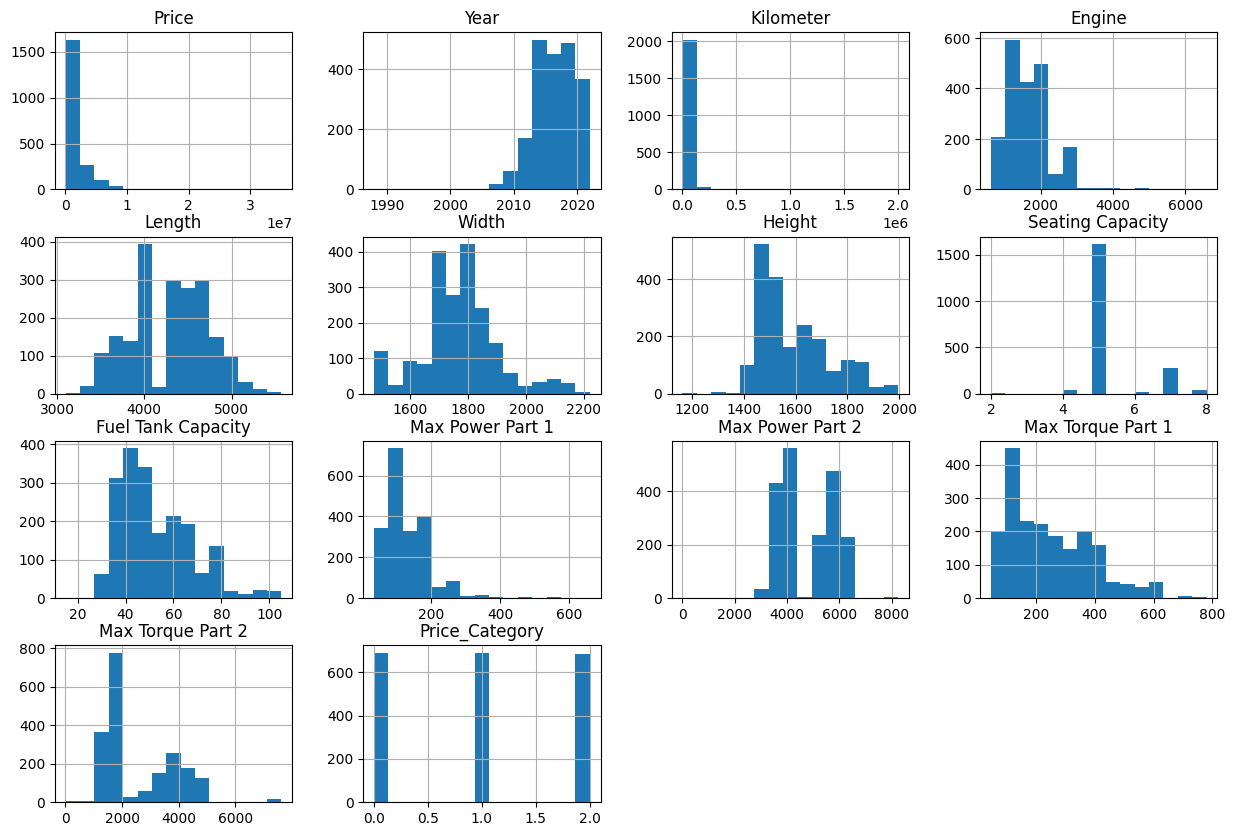

In [6]:
data.hist(bins=15, figsize=(15, 10))
plt.show()

Correlation matrix before fixing our missing data.

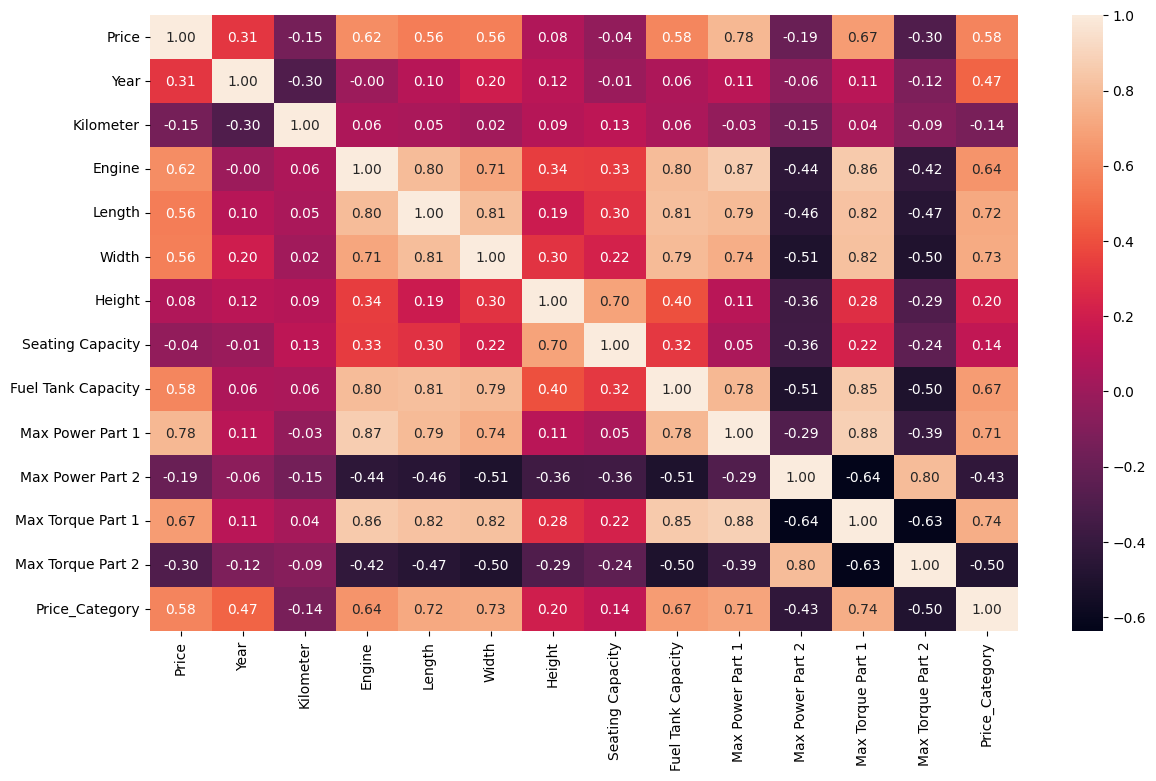

In [7]:
def draw_correlation_matrix(data):
    numeric_df = data.select_dtypes(include=[np.number])  # Select only numeric columns
    corr = numeric_df.corr()
    # Generate a heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(corr, annot=True, fmt=".2f")
    plt.show()

draw_correlation_matrix(data)


categorized data analysis

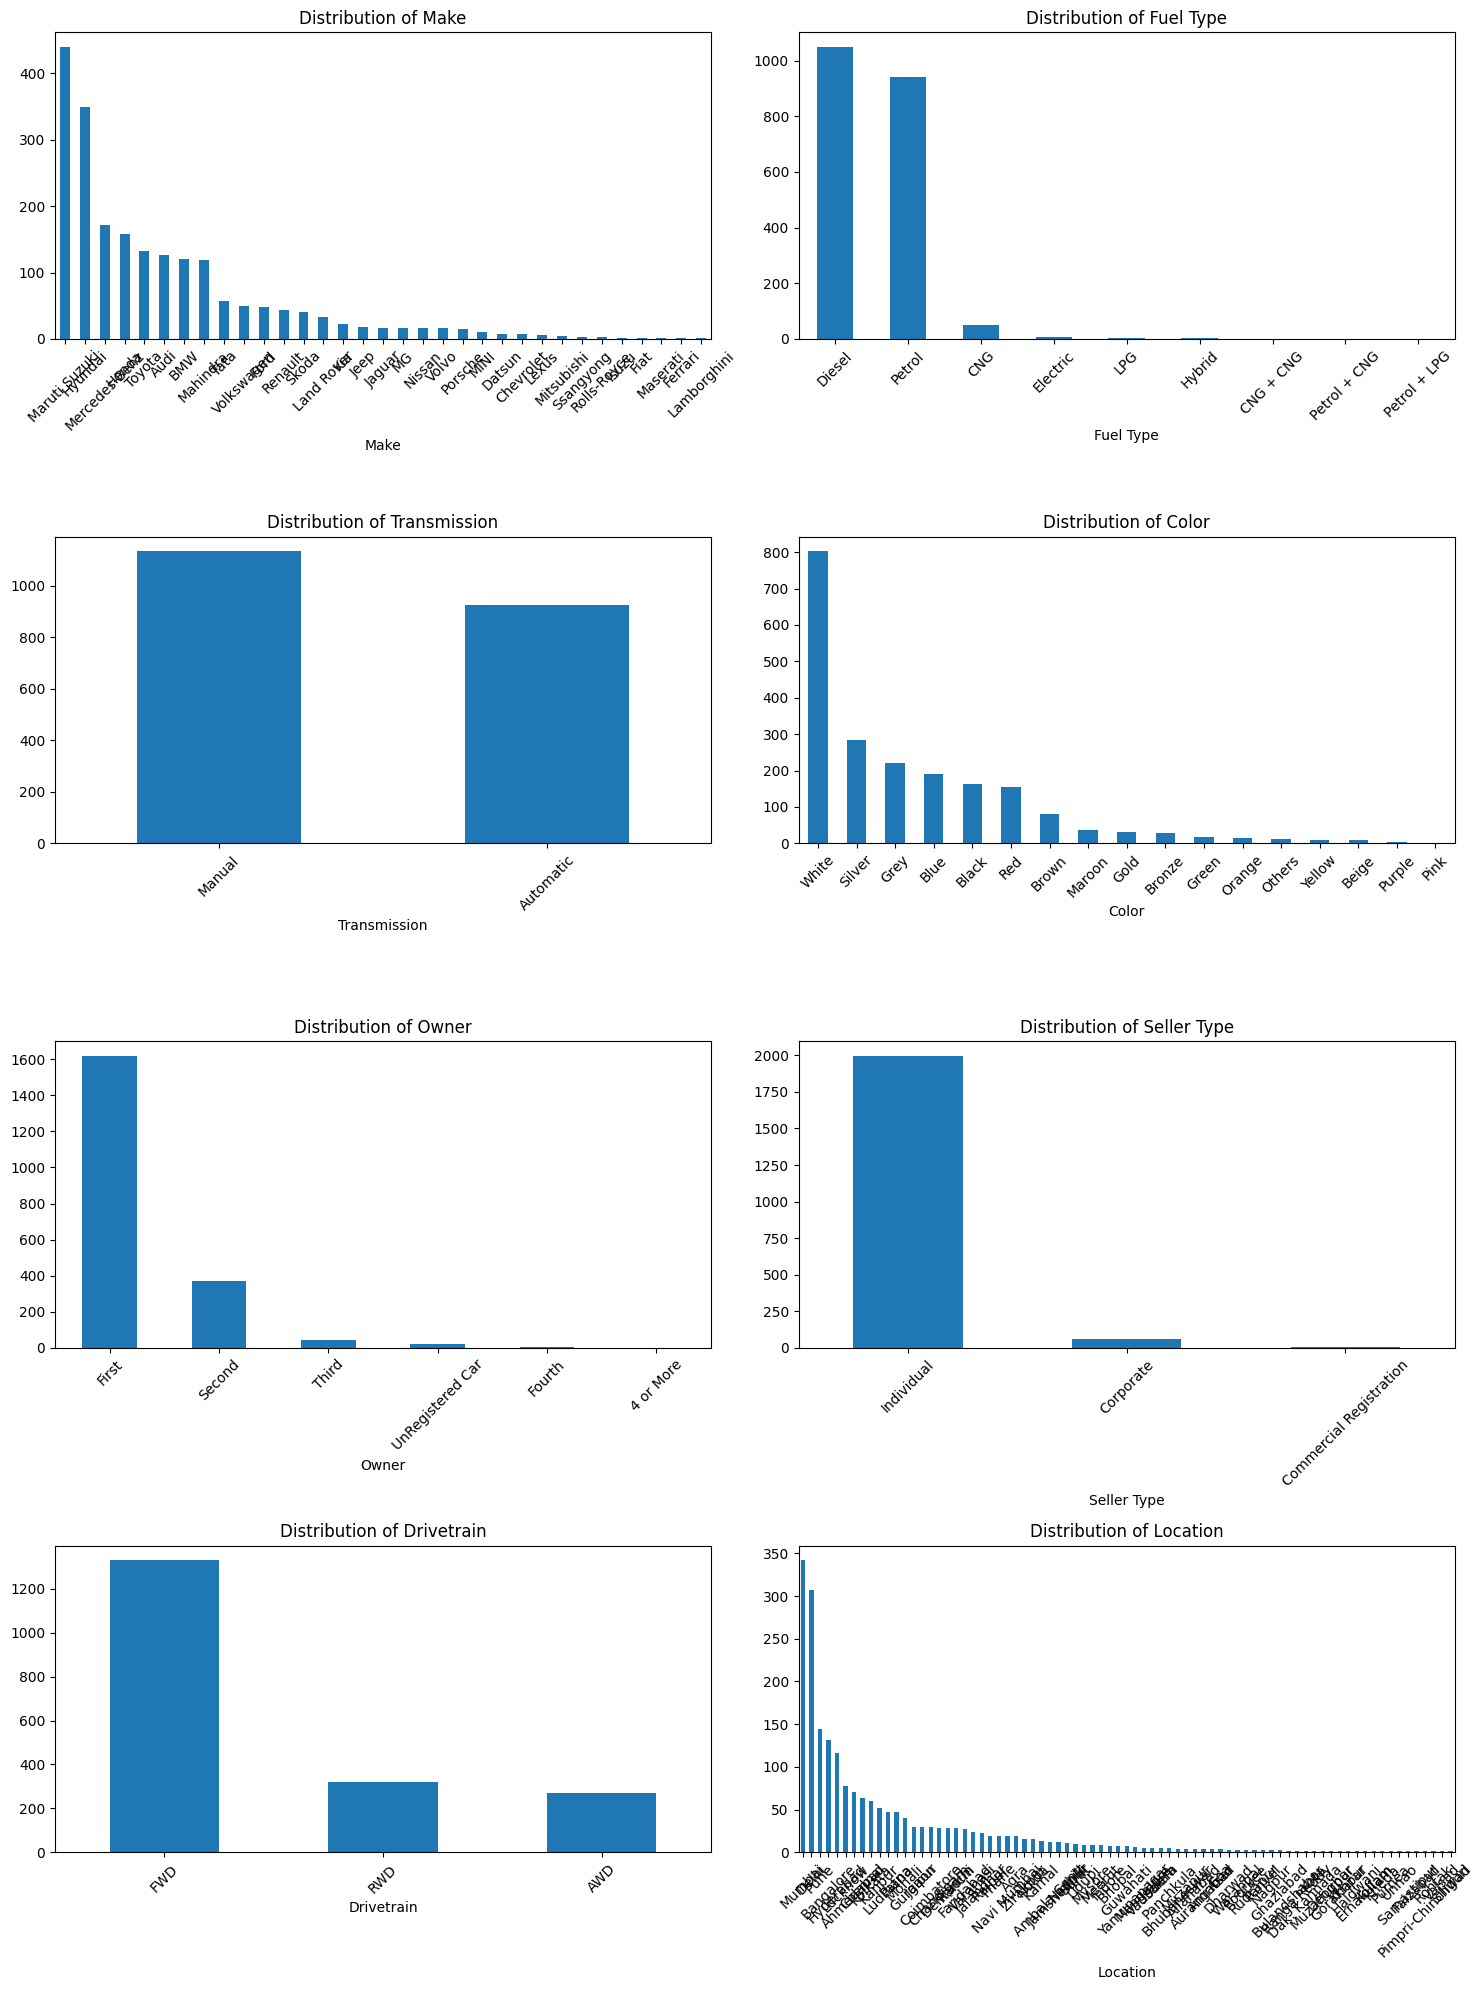

In [8]:
def draw_categorical(column, num):
    plt.subplot(n_rows_categorized, 2, num + 1)
    data[column].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)


plt.figure(figsize=(15, 5 * n_rows_categorized))
for i, cat in enumerate(cats):
    draw_categorical(cat, i)

plt.tight_layout()
plt.show()


Scatter plot for numerical data vs price 

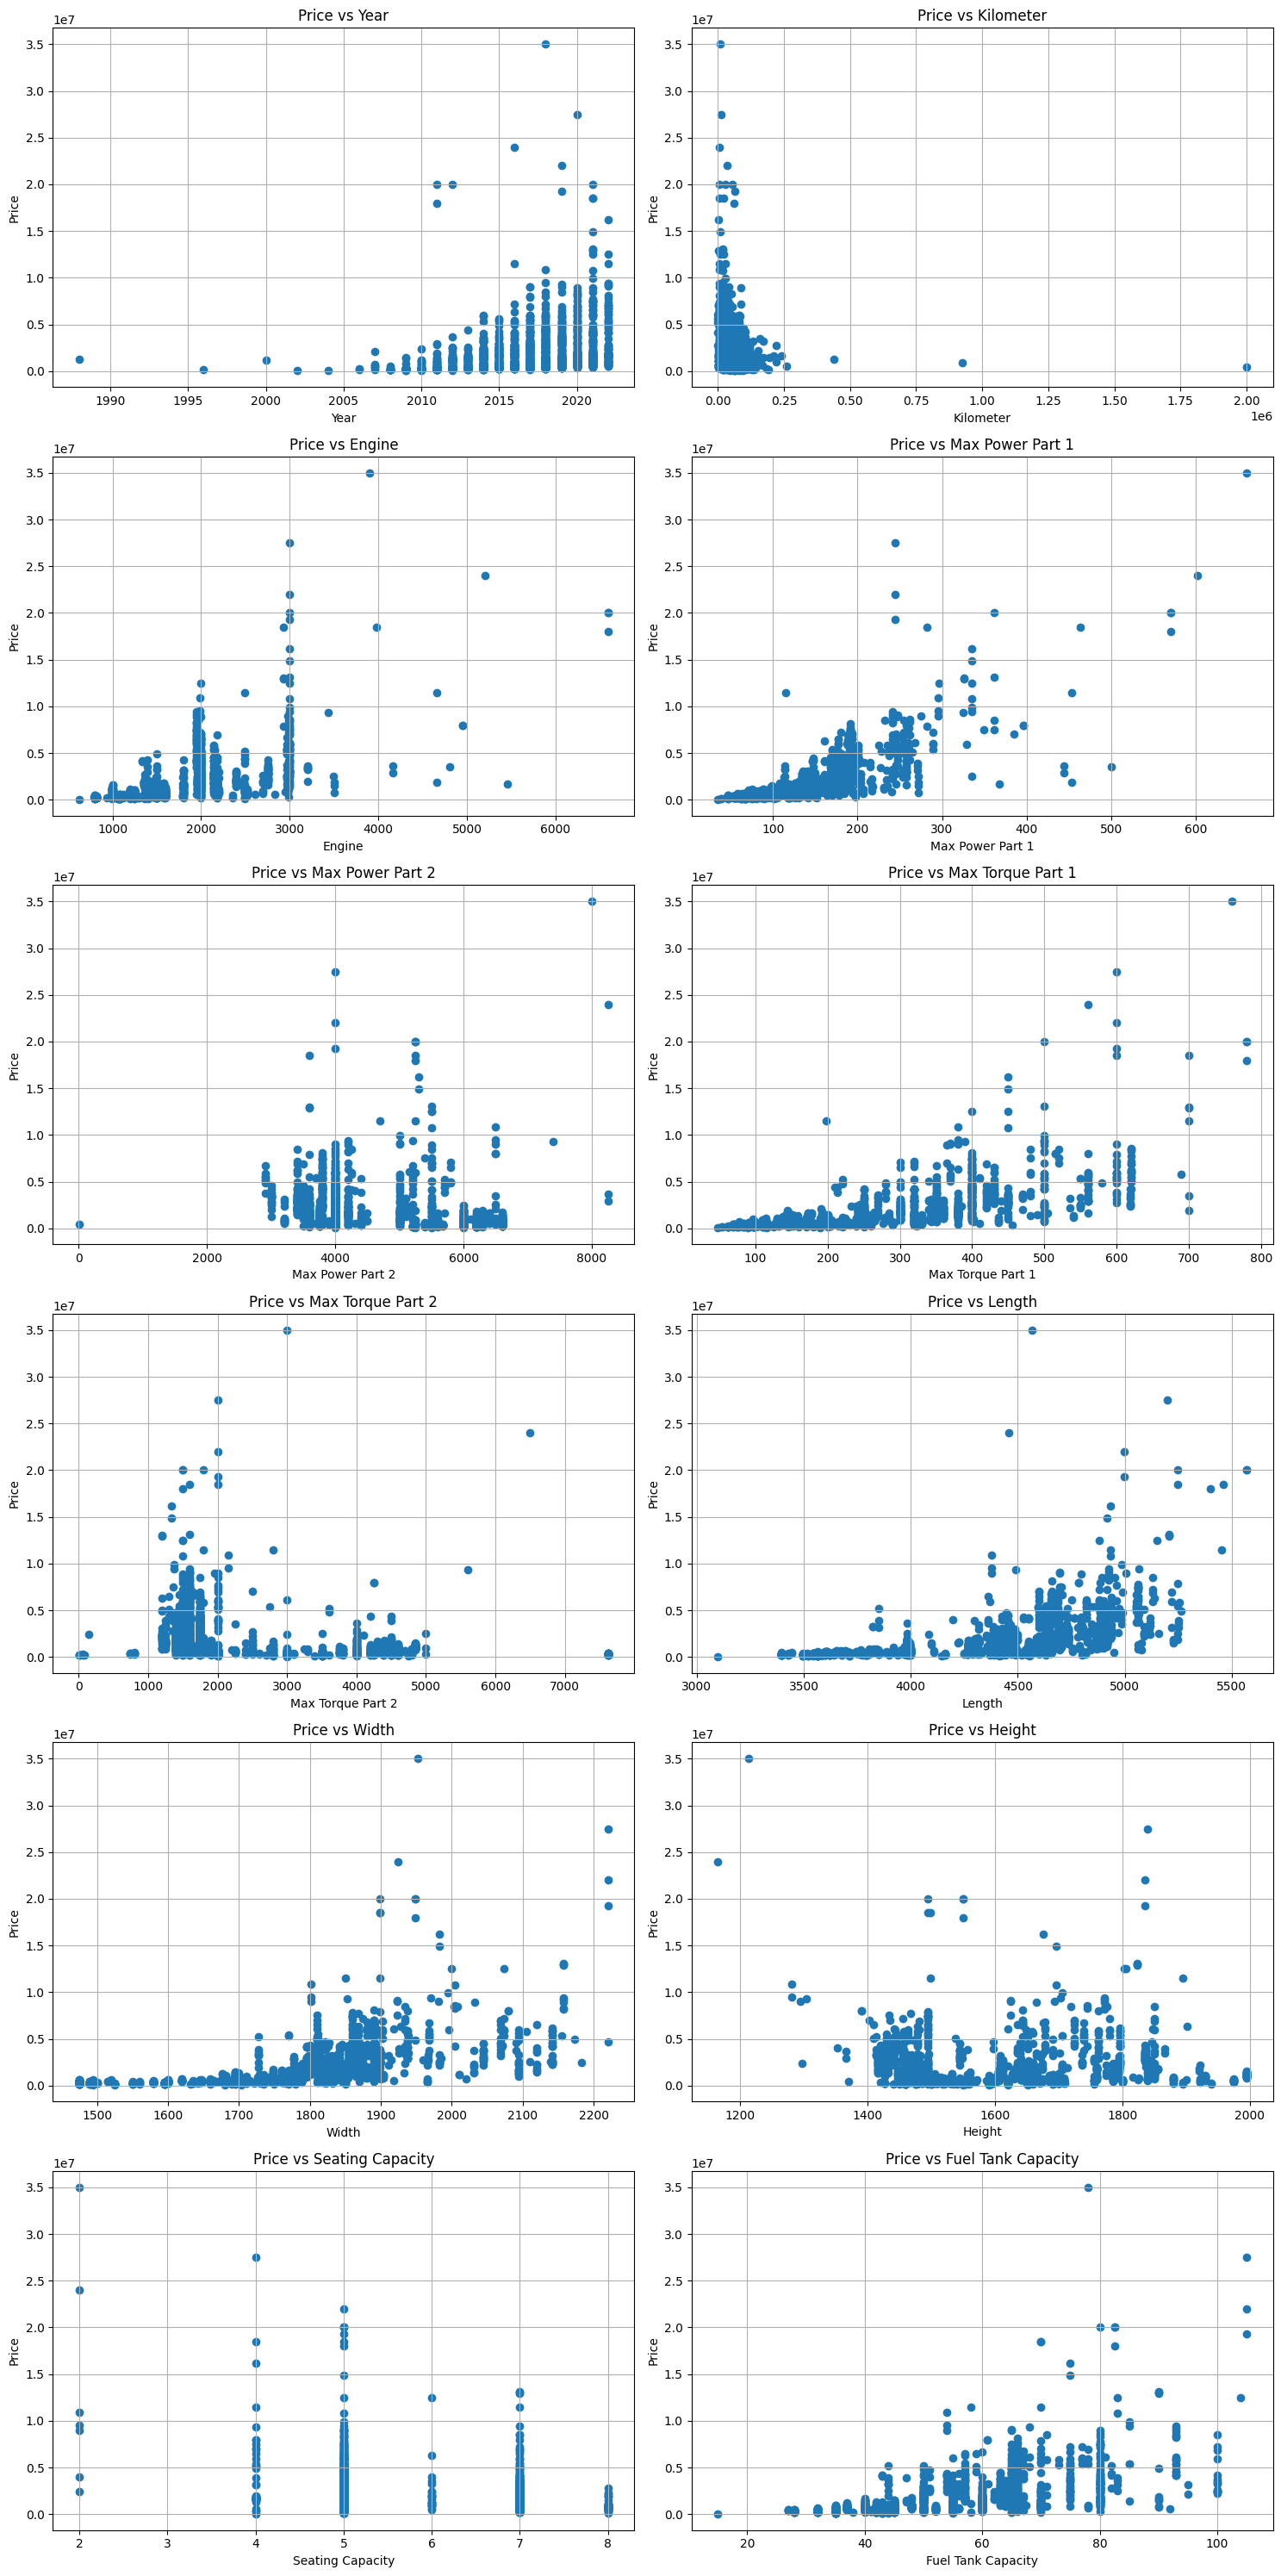

In [9]:
def draw_scatter(column, num):
    plt.subplot(n_rows_numerical, 2, num + 1)
    plt.grid(True)
    plt.scatter(data[column], data['Price'])
    plt.title(f'Price vs {column}')
    plt.xlabel(column)
    plt.ylabel('Price')

plt.figure(figsize=(15, 5 * n_rows_numerical))
for i, numeric in enumerate(numerical_parts):
    draw_scatter(numeric, i)

plt.tight_layout()
plt.show()


draw box plots for Comparisons between categorized columns and price

<Figure size 1500x2000 with 0 Axes>

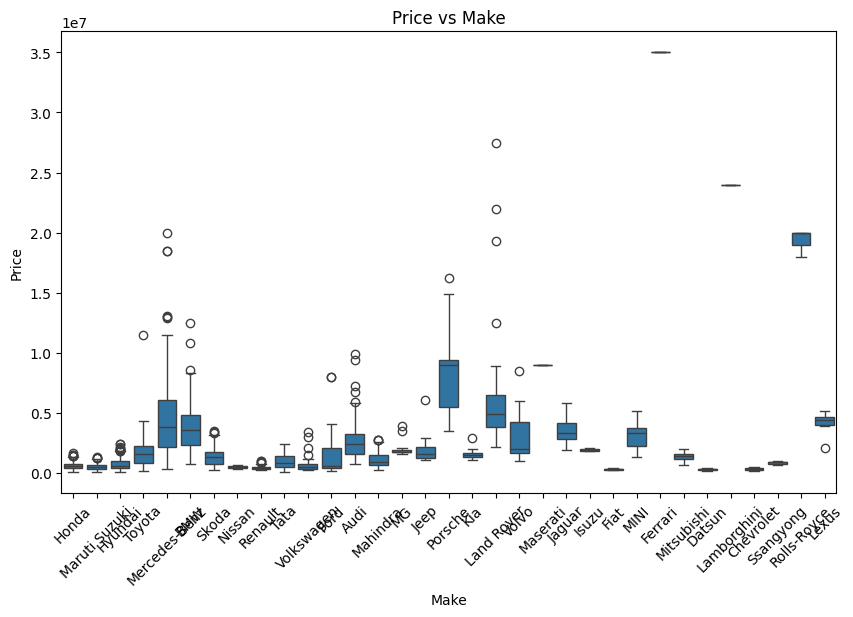

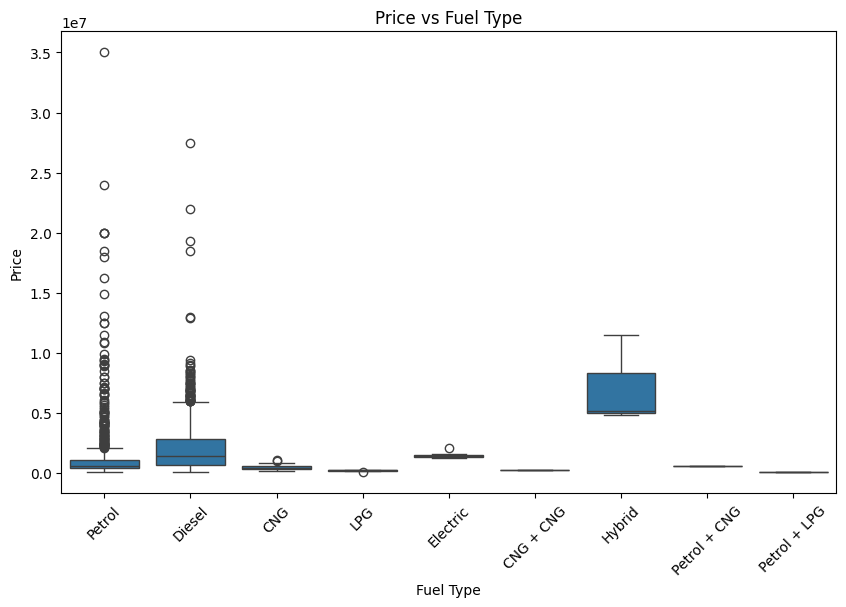

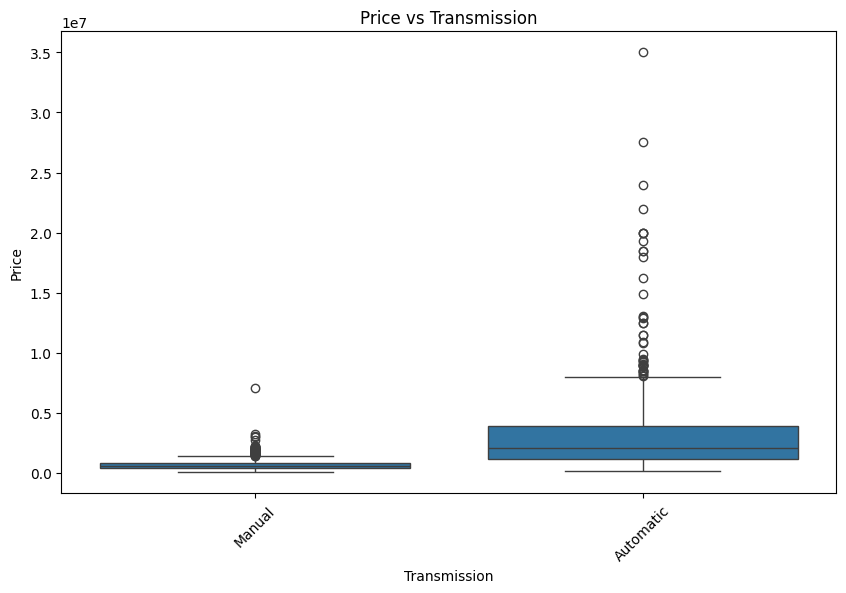

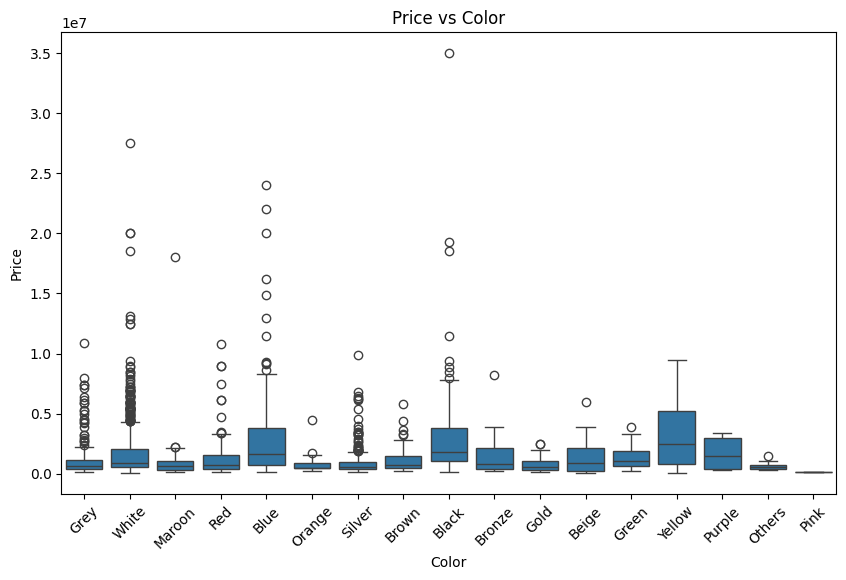

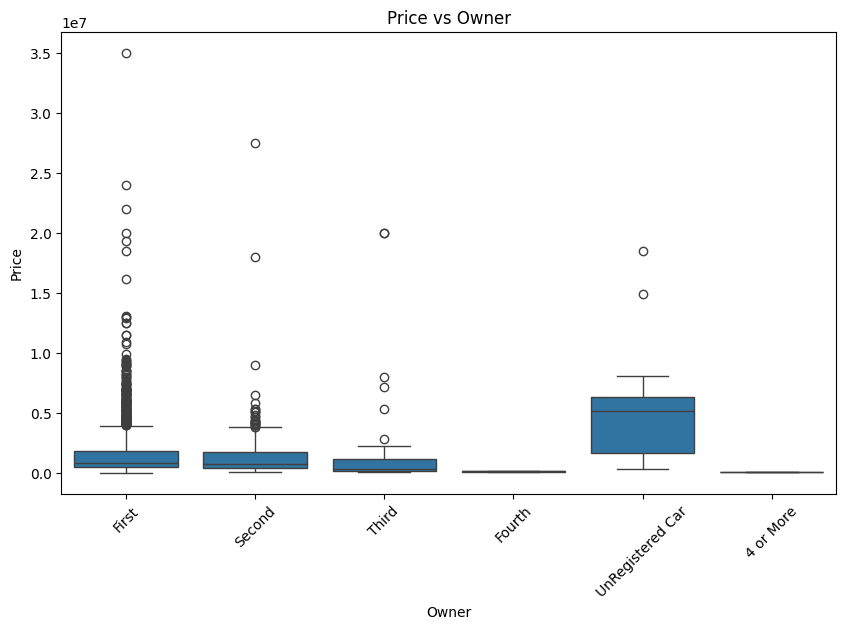

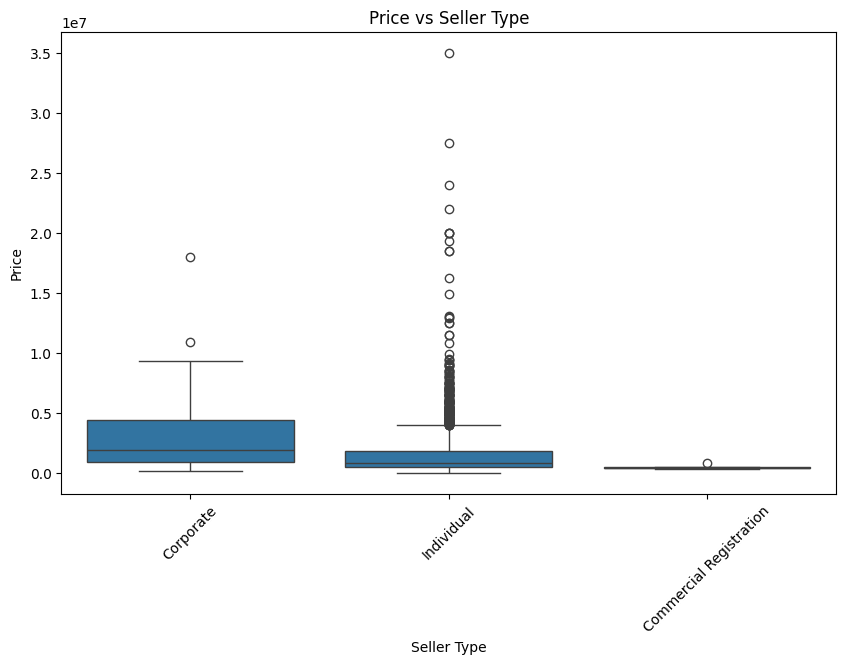

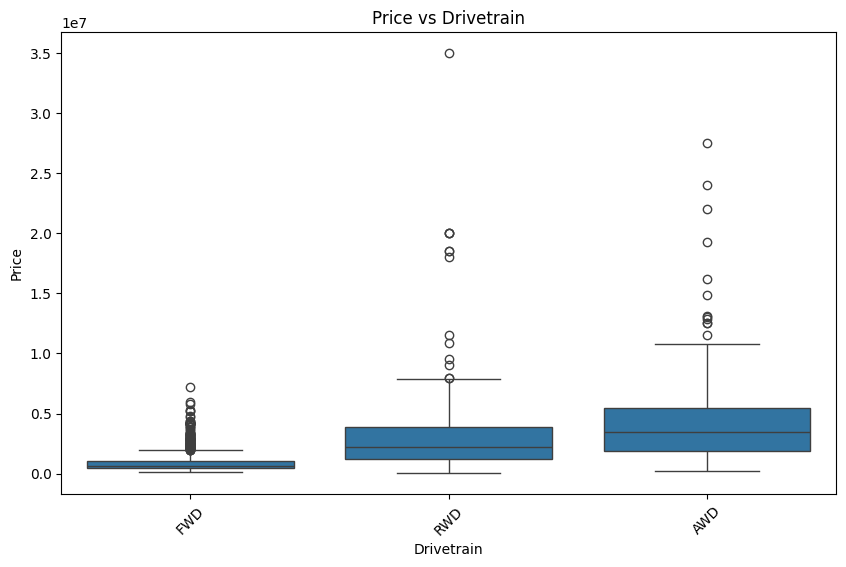

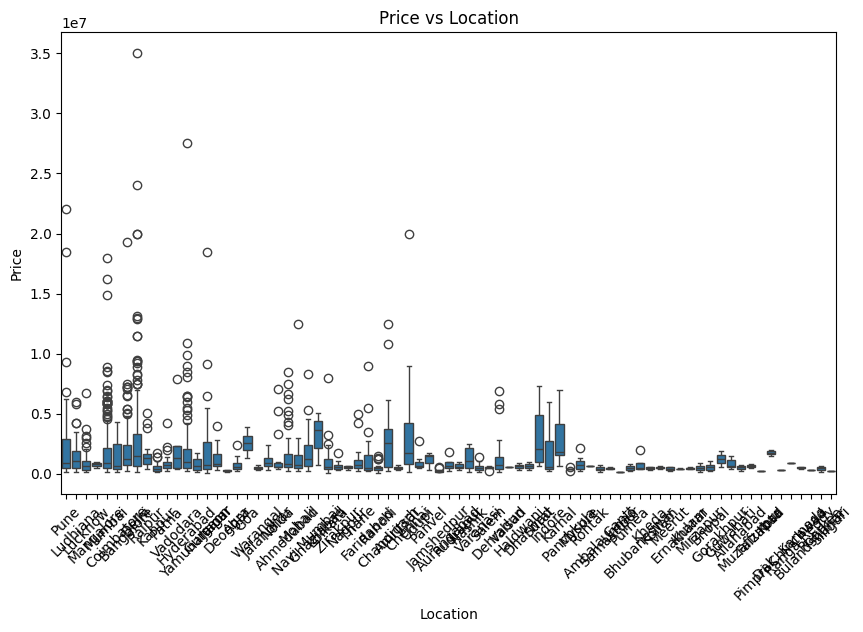

In [10]:

def draw_box_plot(column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column, y='Price', data=data)
    plt.title(f'Price vs {column}')
    plt.xticks(rotation=45)
    plt.show()

plt.figure(figsize=(15, 5 * n_rows_categorized))
for i, cat in enumerate(cats):
    draw_box_plot(cat)

# Question 3
in this question we need to fill missing data

in the last question I printed the number of missing data in every column so no we want to go for them and use some ways to fill them.

### Fuel Tank Capacity
first I want to fill Fuel Tank Capacity column for this purpose I looked a lot at data and I figured out the best way to handle this one is by looking at the capacity of engine so I want to use mean of cars with the same engine capacity but we know there are some data that missed both of these features for those data (that I checked there is not a lot of them) I want to use median of all data.

but before that I removed electric cars from our dataset because after EDA part of our project I just figured out these cars have so many empty data which are not depending on our other data and they are only causing problems for us (they are only 7 data)

In [11]:
data = data[data['Fuel Type'] != 'Electric']
data.reset_index(drop=True, inplace=True)
missed_fuel_data_with_engine = data['Fuel Tank Capacity'].isna() & data['Engine'].notna()
for engine_val in data['Engine'].unique():
    mean_fuel_capacity = data[data['Engine'] == engine_val]['Fuel Tank Capacity'].mean()
    if not np.isnan(mean_fuel_capacity):
        # If not NaN, round the mean value
        mean_fuel_capacity = round(mean_fuel_capacity)
    data.loc[missed_fuel_data_with_engine & (data['Engine'] == engine_val), 'Fuel Tank Capacity'] = mean_fuel_capacity

data['Fuel Tank Capacity'].fillna(data['Fuel Tank Capacity'].median(), inplace=True)


### dimensions of the car

in this part I want to fill missing data for Length Width and Height.
my strategy for this part is to find cars with same "Made" feature.
and we have "Fuel Tank Capacity" feature from last part and I want to find cars with similar Made and Fuel Tank Capacity to calculate the mean of their dimension for our missing data.

In [12]:
def fill_missing_dimensions(row, feature, tolerance=10):
    if pd.isna(row[feature]):

        similar_cars = data[(data['Make'] == row['Make']) & 
                          (data['Fuel Tank Capacity'] >= row['Fuel Tank Capacity'] - tolerance) & 
                          (data['Fuel Tank Capacity'] <= row['Fuel Tank Capacity'] + tolerance)]
        
        mean_value = round(similar_cars[feature].mean())

        return mean_value if pd.notna(mean_value) else row[feature]
    else:
        return row[feature]
    
for feature in ['Length', 'Width', 'Height', 'Seating Capacity']:
    data[feature] = data.apply(lambda row: fill_missing_dimensions(row, feature), axis=1)
    

### Engine Capacity
I want to use a regression model to calculate my engine capacity based on some features.
as you can see these features are the ones we fixed on two last parts.

In [13]:
def predict_empty_engine(features, column):
    train_df = data.dropna(subset=features + ['Engine'])
    test_df = data[data[column].isnull()]
    if(len(test_df)):
        X_train = train_df[features]
        y_train = train_df[column]
        X_test = test_df[features]
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        predicted_engine_sizes = lr.predict(X_test)
        data.loc[data['Engine'].isnull(), 'Engine'] = predicted_engine_sizes

engine_features = ['Year', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']
predict_empty_engine(engine_features, "Engine")

### Drivetrain
for this one I used these features => Year-Made-Width-Length-Height and I watched for most repeated Drivetrain.

In [14]:
def fill_missing_drivetrain(row, tolerance=200):
    if pd.isna(row['Drivetrain']):
        similar_cars = data[(data['Make'] == row['Make']) & 
                          (data['Year'] == row['Year']) & 
                          (abs(data['Length'] - row['Length']) <= tolerance) &
                          (abs(data['Width'] - row['Width']) <= tolerance) &
                          (abs(data['Height'] - row['Height']) <= tolerance)]

        if not similar_cars.empty:
            most_common_drivetrain = similar_cars['Drivetrain'].mode()

            if not most_common_drivetrain.empty:
                return data['Drivetrain'].mode()
            
        return data['Drivetrain'].mode()
    else:
        return row['Drivetrain']

if(not len(data[data['Drivetrain'].isnull()])==0):
    data['Drivetrain'] = data.apply(lambda row: fill_missing_drivetrain(row), axis=1)


### Max Power and Torque
for this one I split these 2 data to 4 columns earlier and now we just want to find cars with same type of engine capacity to fill these data

In [15]:
def fill_missing_part1(row, feature, tolerance=100):
    if pd.isna(row[feature]):
        similar_cars = data[(abs(data['Engine'] - row['Engine']) <= tolerance) & 
                          (data[feature].notna())]

        mean_value = similar_cars[feature].mean()

        if not pd.isna(mean_value):
            return mean_value
        else:
            return data[feature].mode()
    else:
        return row[feature]

def fill_missing_part2(row, feature, tolerance=100):
    if pd.isna(row[feature]):
        similar_cars = data[(abs(data['Engine'] - row['Engine']) <= tolerance) & 
                          (data[feature].notna())]

        if not similar_cars.empty:
            most_common_value = similar_cars[feature].mode()

            if not most_common_value.empty:
                return most_common_value.iloc[0]
        return data[feature].mode()
    else:
        return row[feature]
    
for part1_feature in ['Max Power Part 1', 'Max Torque Part 1']:
    data[part1_feature] = data.apply(lambda row: fill_missing_part1(row, part1_feature), axis=1)

for part2_feature in ['Max Power Part 2', 'Max Torque Part 2']:
    data[part2_feature] = data.apply(lambda row: fill_missing_part2(row, part2_feature), axis=1)


# Question 4
in this question we will draw Correlation matrix again and check how is the Correlation of our features

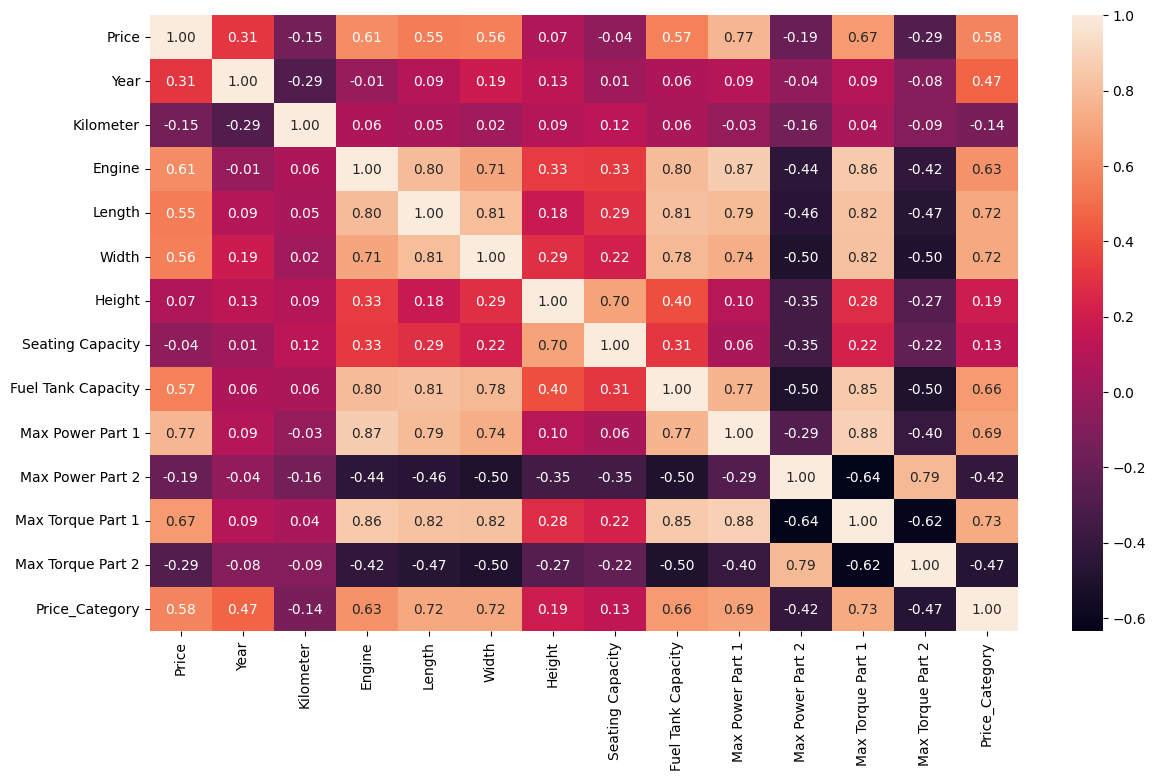

In [16]:
draw_correlation_matrix(data)

we can find a lot of useful data from this matrix
for example if you see the relation between price which is our target and other features you can see some features like Engine have a stronger positive correlation with 'Price' which makes them good candidates for predicting 'Price'.

but there is another important thing that we are looking for which is other features correlating with each other instead of price and these pairs may not be ideal to use together in a linear regression model due to multicollinearity and I want to use PCA function to create two new features.

Here are some of the highly correlated feature pairs:

'Engine' and 'Max Power Part 1' (0.87)

'Engine' and 'Max Torque Part 1' (0.86)

'Engine' and 'Fuel Tank Capacity' (0.80)

'Length' and 'Width' (0.81)

'Max Power Part 1' and 'Max Torque Part 1' (0.88)

'Max Power Part 1' and 'Fuel Tank Capacity' (0.77)

'Max Torque Part 1' and 'Fuel Tank Capacity' (0.85)




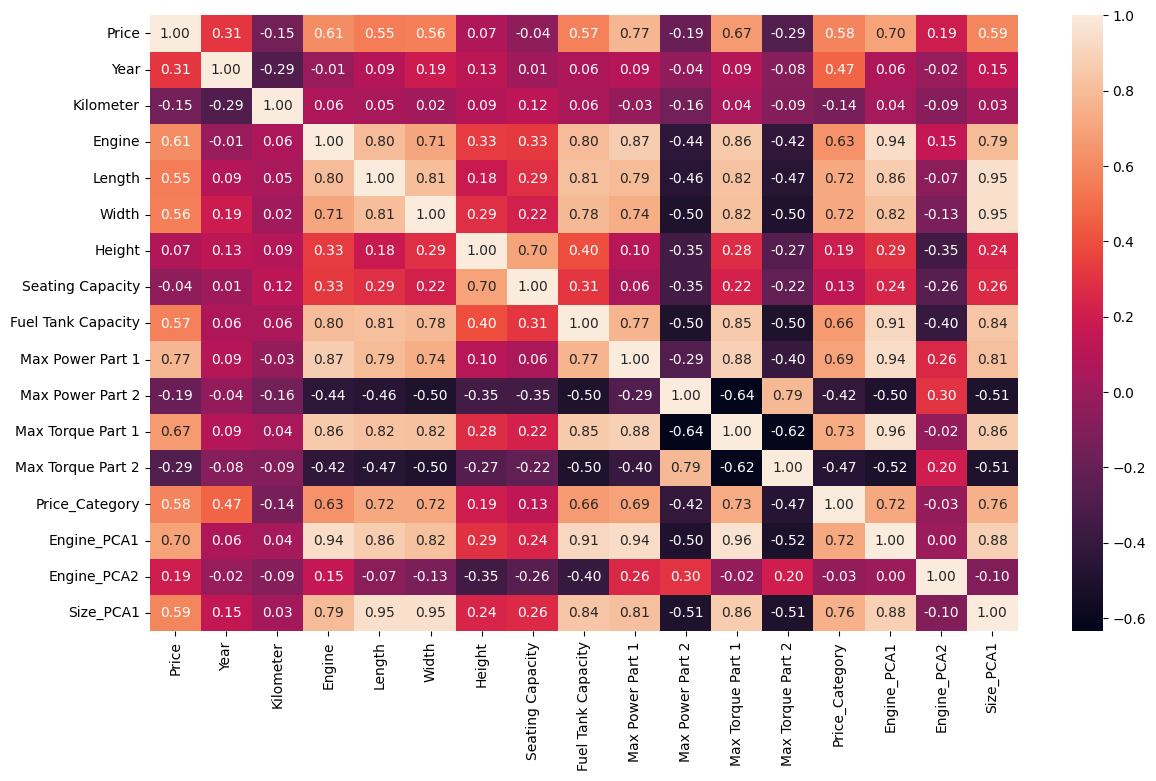

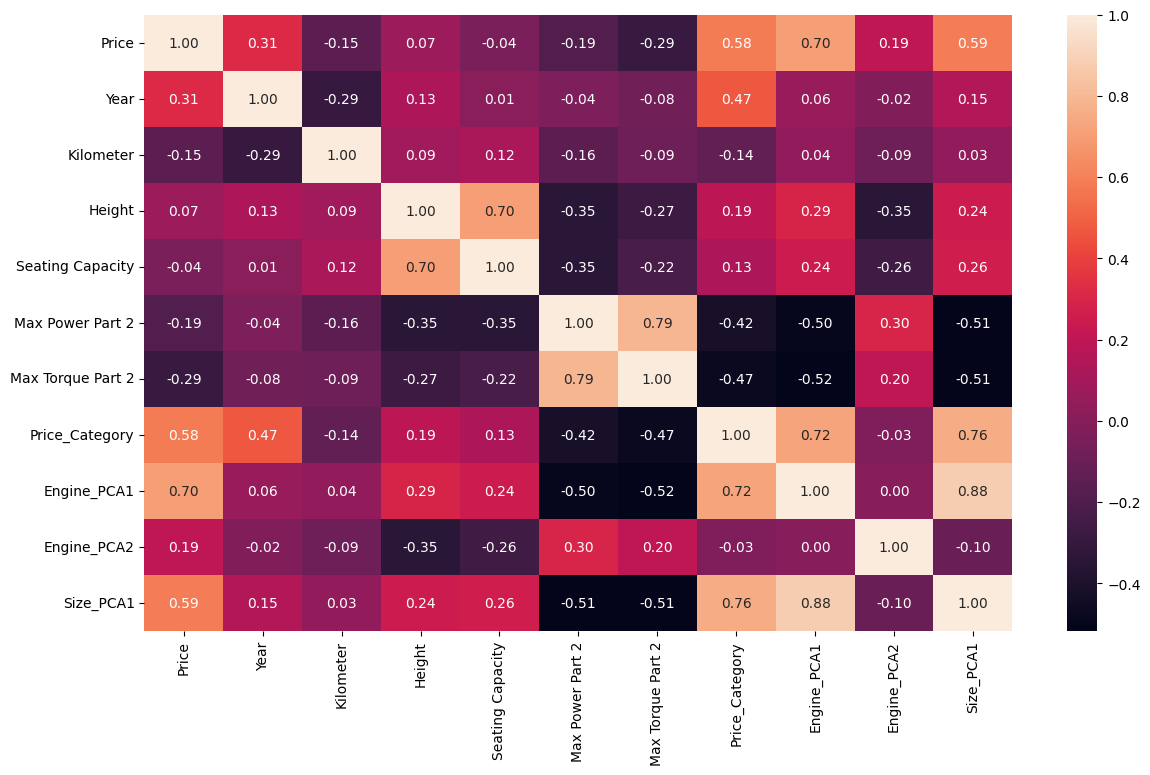

In [17]:
def PCA_handler(features, pcaName, n_components=2):

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[features])

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(scaled_features)
    columns= []
    for i in range(n_components):
        columns.append(f'{pcaName}{i+1}')

    pca_df = pd.DataFrame(data=components, columns=columns)
    return pca_df
    

engine_features= ['Engine', 'Max Power Part 1', 'Max Torque Part 1', 'Fuel Tank Capacity']
size_features = ['Length', 'Width']
engine_pca_df= PCA_handler(engine_features, 'Engine_PCA')
data = pd.concat([data, engine_pca_df], axis=1)
size_pca_df=PCA_handler(size_features, 'Size_PCA', 1)
data = pd.concat([data, size_pca_df], axis=1)
draw_correlation_matrix(data)
data.drop(columns=engine_features, axis=1, inplace=True)
data.drop(columns=size_features, axis=1, inplace=True)
draw_correlation_matrix(data)


and now you can see in new matrix that we have two new features that can help us predicting our target price.

# Question 5
encoding our categorized data

as you mentioned in the question I didn't use get_dummies and LabelEncoder which can help us encode our data which has ordinal relationship between the categories.

for some others which are not ordinal relationship data I used frequency_encoding.

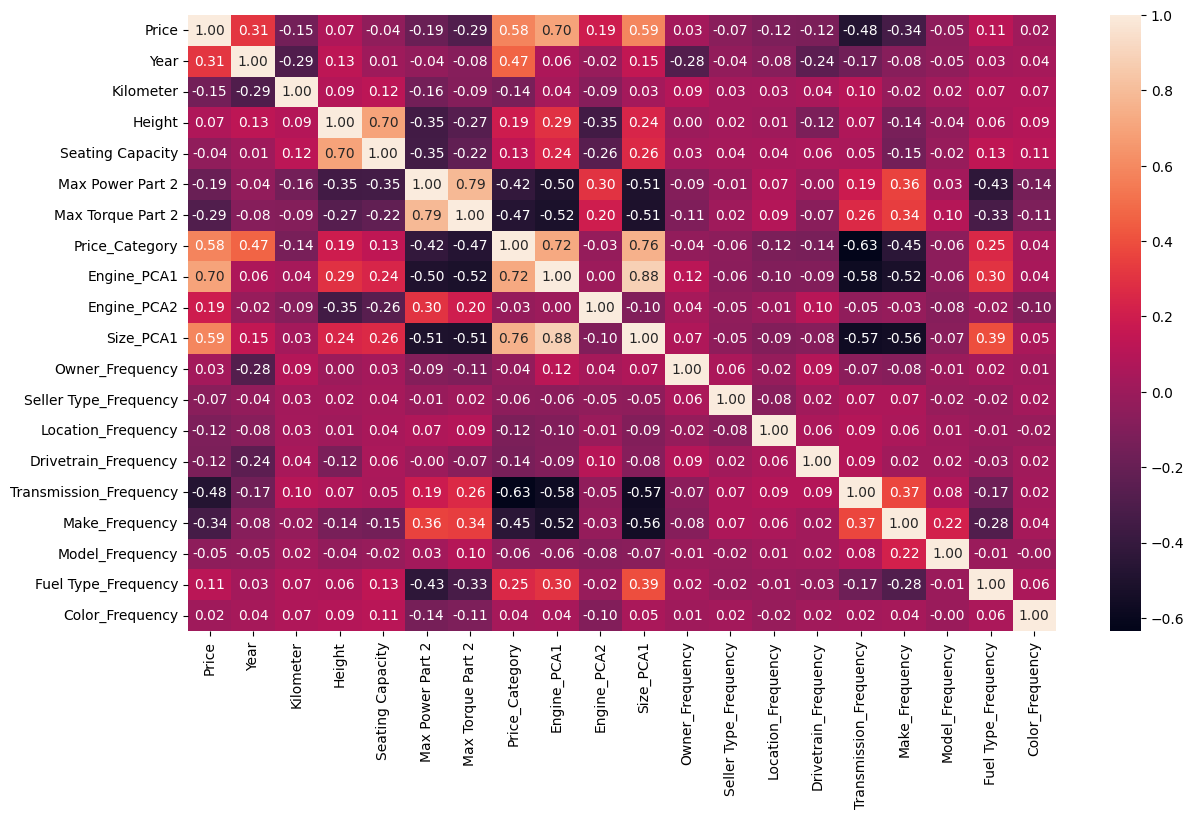

In [18]:
label_encoders = {}
data['Drivetrain'] = data['Drivetrain'].str.replace(r'[\[\]]', '', regex=True)
columns_Label= ['Owner', 'Seller Type', 'Location', 'Drivetrain', 'Transmission']
columns_frequency= ['Make', 'Model', 'Fuel Type', 'Color']
for column in columns_Label:
    label_encoder = LabelEncoder()
    data[f'{column}_Frequency'] = label_encoder.fit_transform(data[column])
    label_encoders[column] = label_encoder

for column in columns_frequency:
    make_frequency = data[column].value_counts(normalize=True)
    data[f'{column}_Frequency'] = data[column].map(make_frequency)

data.drop(columns=columns_Label, axis=1, inplace=True)
data.drop(columns=columns_frequency, axis=1, inplace=True)
draw_correlation_matrix(data)


# Question 6 and 7

first I used my get_split_data function to get my test and train data and I used some of our features which had better results in our matrix

after that I used np.logspace for my alpha and it will go from 10^-4 to 10^4 which helps us find better results.

after finding best parameter I figured out that our error number is too high and it can have many reasons for example:
- we have to find better features
- maybe our problem is not going to solve with linear regression model

In [38]:
def grid_search():
    local_data= data[['Price', 'Price_Category', 'Size_PCA1', 'Engine_PCA1', 'Year', 'Transmission_Frequency', 'Max Torque Part 2', 'Kilometer']]

    train_set, test_set=get_split_data(local_data)
    X = train_set.drop('Price', axis=1)
    X = X.drop('Price_Category', axis=1) 
    y = train_set['Price']
    param_grid = {'alpha': np.logspace(-4, 4, 20)}
    ridge = Ridge()
    grid_ridge = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error')
    grid_ridge.fit(X, y)


    lasso = Lasso()
    grid_lasso = GridSearchCV(lasso, param_grid, scoring='neg_mean_squared_error')
    grid_lasso.fit(X, y)

    best_params_ridge = grid_ridge.best_params_
    best_score_ridge = grid_ridge.best_score_

    best_params_lasso = grid_lasso.best_params_
    best_score_lasso = grid_lasso.best_score_
    print("Best Ridge:", best_params_ridge, best_score_ridge)
    print("Best Lasso:", best_params_lasso, best_score_lasso)

    ridge = Ridge(alpha=best_params_ridge['alpha'])
    lasso = Lasso(alpha=best_params_lasso['alpha'])
    ridge.fit(X, y)
    lasso.fit(X, y)
    X_test = test_set.drop('Price', axis=1)
    X_test = X_test.drop('Price_Category', axis=1) 
    y_test = test_set['Price']
    y_pred_ridge = ridge.predict(X_test)
    y_pred_lasso = lasso.predict(X_test)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    rmse_ridge = np.sqrt(mse_ridge)
    rmse_lasso = np.sqrt(mse_lasso)
    r2_ridge = r2_score(y_test, y_pred_ridge)
    r2_lasso = r2_score(y_test, y_pred_lasso)
    print(f"Ridge Regression: MSE = {mse_ridge}, RMSE = {rmse_ridge}, R² = {r2_ridge}")
    print(f"Lasso Regression: MSE = {mse_lasso}, RMSE = {rmse_lasso}, R² = {r2_lasso}")
    comparison_df = pd.DataFrame({'Actual Price': y_test, 'Predicted Price (Ridge)': y_pred_ridge})
    comparison_df['Difference'] = comparison_df['Actual Price'] - comparison_df['Predicted Price (Ridge)']
    return best_params_ridge['alpha'], best_params_lasso['alpha']
best_ridge_alpha, best_lasso_alpha= grid_search()

Best Ridge: {'alpha': 4.281332398719396} -2565992552957.6865
Best Lasso: {'alpha': 0.0001} -2566076892396.217
Ridge Regression: MSE = 2438022402736.8267, RMSE = 1561416.793408098, R² = 0.5875399832957707
Lasso Regression: MSE = 2439847952657.4473, RMSE = 1562001.2652547525, R² = 0.5872311402146291


# Question 8
k-fold cross validation

we use this method and it will run the process 5 times for us.

- The KFold class is used to generate train and test indices for each fold.
- In each iteration of the loop, the model is trained on the training subset and evaluated on the testing subset.
- RMSE is calculated for each fold and stored in a list.
- After all folds are processed, the average RMSE across all folds is calculated and printed.

as you can see how it works it will shuffle more our training data and create model based on these iterations.

reasons we use k-fold:

1. Better Model Assessment By splitting the dataset into k different subsets
2. Reducing Variance because it runs with different splits
3. Utilizing All Available Data In scenarios where the amount of available data is limited
4. Balancing Bias and Variance but careful because Using a larger number of folds (k) can decrease bias but might increase variance and computational costs. 

hereee
Average RMSE over 5 folds and Ridge: 1677848.5392604899
Average R2 over 5 folds and Ridge: 0.45350323343090215
Average RMSE over 5 folds and Lasso: 1677848.664842692
Average R2 over 5 folds and Lasso: 0.45319087300193467


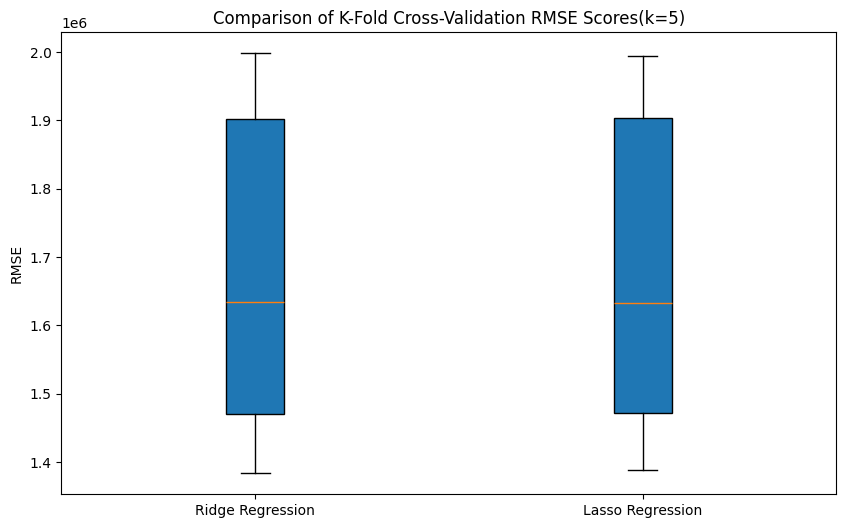

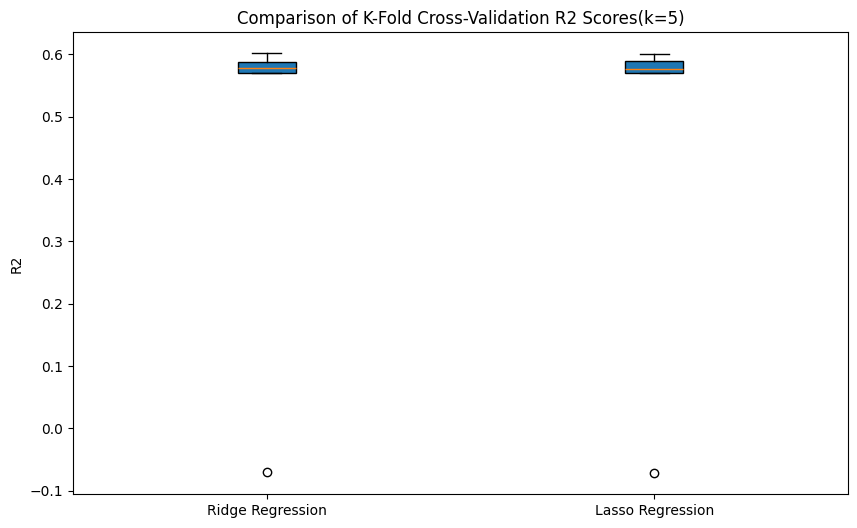

In [57]:
def k_fold(model_name, k=5):
    local_data= data[['Price', 'Price_Category', 'Size_PCA1', 'Engine_PCA1', 'Year', 'Transmission_Frequency', 'Max Torque Part 2', 'Kilometer']]
    X = local_data.drop('Price', axis=1)
    X = X.drop('Price_Category', axis=1)
    y = local_data['Price']
    if(model_name == 'Ridge'):
        print('hereee')
        k_fold_model = Ridge(alpha=best_ridge_alpha)
    else:
        k_fold_model = Lasso(alpha=best_lasso_alpha)
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    rmse_scores = []
    r2_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        k_fold_model.fit(X_train_scaled, y_train)

        y_pred = k_fold_model.predict(X_test_scaled)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        rmse_scores.append(rmse)
        r2_scores.append(r2)
    average_rmse = np.mean(rmse_scores)
    average_r2 = np.mean(r2_scores)
    print(f"Average RMSE over {k} folds and {model_name}: {average_rmse}")
    print(f"Average R2 over {k} folds and {model_name}: {average_r2}")
    return rmse_scores, r2_scores

ridge_rmse_scores, ridge_r2_scores= k_fold('Ridge')
lasso_rmse_scores, lasso_r2_scores= k_fold('Lasso')

plt.figure(figsize=(10, 6))
plt.boxplot([ridge_rmse_scores, lasso_rmse_scores], patch_artist=True, labels=['Ridge', 'Lasso'])

plt.title('Comparison of K-Fold Cross-Validation RMSE Scores(k=5)')
plt.ylabel('RMSE')
plt.xticks([1, 2], ['Ridge Regression', 'Lasso Regression'])
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot([ridge_r2_scores, lasso_r2_scores], patch_artist=True, labels=['Ridge', 'Lasso'])

plt.title('Comparison of K-Fold Cross-Validation R2 Scores(k=5)')
plt.ylabel('R2')
plt.xticks([1, 2], ['Ridge Regression', 'Lasso Regression'])
plt.show()

